This notebook is a duplicate of the one named `timing-vs-gaiaedr3-position-comparison-with-true-match`, where only MSPs were included.

In [1]:
from functools import reduce

import numpy as np
import seaborn as sns
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Table, join, vstack
from astropy.time import Time
from matplotlib import pyplot as plt
from psrcrf_tools import *
from statsmodels.iolib.table import SimpleTable

/Users/Neo/Scisoft/miniconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# 1 Data preparation

## 1.1 Load the database

Read the timing solution data.

In [2]:
timing_table = Table.read(
    "../data/timing_edr3.fits",
)
timing_table.sort("psr_name")

Remove one pulsar (PSR J1546-5302) that does not have proper motion and parallax estimates in the *Gaia* EDR3.

In [3]:
mask = (
    (timing_table["psr_name"] != "J1435-6100")
    & (timing_table["psr_name"] != "J1955+2908")
    & (timing_table["psr_name"] != "J1546-5302")
)
timing_table = Table(timing_table[mask], masked=False)

Add unit information

In [4]:
timing_table["ra"].unit = u.deg
timing_table["dec"].unit = u.deg
timing_table["pmra"].unit = u.mas / u.yr
timing_table["pmdec"].unit = u.mas / u.yr
timing_table["plx"].unit = u.mas
timing_table["ra_err"].unit = u.mas
timing_table["dec_err"].unit = u.mas
timing_table["pmra_err"].unit = u.mas / u.yr
timing_table["pmdec_err"].unit = u.mas / u.yr
timing_table["plx_err"].unit = u.mas

Load the cross-match table.

In [5]:
# edr3_antf_table = Table.read("../data/edr3_psrcatv1.65.fits")
# edr3_antf_table = Table.read("../data/edr3_psrcatv1.66.fits")
edr3_antf_table = Table.read("../data/edr3_psrcatv1.67.fits")
edr3_antf_table.sort("name")

Find millisecond pulsars (MSPs) using the classification provided in J. Antoiniadis (2021).

In [6]:
B_over_G = 3.2e19 * np.sqrt(edr3_antf_table["p0"] * edr3_antf_table["p1"])

mask = (B_over_G <= 1e10)
msp_list = edr3_antf_table["name"][mask]

Only keep the astrometric parameters from Gaia.

In [7]:
edr3_antf_table = edr3_antf_table[
    "name",
    "source_id",
    "ra",
    "ra_error",
    "dec",
    "dec_error",
    "parallax",
    "parallax_error",
    "pmra",
    "pmra_error",
    "pmdec",
    "pmdec_error",
]

edr3_antf_table.rename_columns(
    [
        "name",
        "ra_error",
        "dec_error",
        "parallax",
        "parallax_error",
        "pmra_error",
        "pmdec_error",
    ],
    ["psr_name", "ra_err", "dec_err", "plx", "plx_err", "pmra_err", "pmdec_err"],
)

Add unit information

In [8]:
edr3_antf_table["ra"].unit = u.deg
edr3_antf_table["dec"].unit = u.deg
edr3_antf_table["pmra"].unit = u.mas / u.yr
edr3_antf_table["pmdec"].unit = u.mas / u.yr
edr3_antf_table["plx"].unit = u.mas
edr3_antf_table["ra_err"].unit = u.mas
edr3_antf_table["dec_err"].unit = u.mas
edr3_antf_table["pmra_err"].unit = u.mas / u.yr
edr3_antf_table["pmdec_err"].unit = u.mas / u.yr
edr3_antf_table["plx_err"].unit = u.mas

Only consider the MSPs in the data.

In [9]:
temp_table = Table([])

for msp_name in msp_list:
    mask = timing_table["psr_name"] == msp_name
    temp_table = vstack((temp_table, timing_table[mask]))

timing_table = Table(temp_table, masked=False)

Supplement the timing table with the Gaia astrometric information.

In [10]:
edr3_timing = join(
    timing_table,
    edr3_antf_table,
    keys="psr_name",
    join_type="left",
    table_names=["t", "g"],
)

count_psr_nb(edr3_timing)

There are 12 pulsars with 36 measurements.


## 1.2 Compute offsets between pulsar positions from timing and Gaia

Propagate the Gaia EDR3 position from J2016.0 to the timing positonal epoch and compute the positional offset,
in the sense of timing minus Gaia.

In [11]:
gaia_epoch = Time("2016.0", format="jyear").mjd
# 57388.5

In [12]:
# Epoch difference in Julian year
dt_y = (edr3_timing["pos_epoch"].value - gaia_epoch) / 365.25 * u.yr

# Cos(decl.) factor for the difference in R.A.
dec_fac = cos(np.deg2rad(edr3_timing["dec_g"].value))

dra = (
    edr3_timing["ra_t"] - edr3_timing["ra_g"]
) * dec_fac - dt_y * edr3_timing["pmra_g"]

ddec = edr3_timing["dec_t"] - edr3_timing["dec_g"] - dt_y * edr3_timing["pmdec_g"]

dra = dra.to(u.mas)
ddec = ddec.to(u.mas)

edr3_timing.add_columns([dra, ddec], names=["dra", "ddec"])

In [13]:
edr3_timing["ra_err_t"] = edr3_timing["ra_err_t"] * dec_fac

dra_err = np.sqrt(
    edr3_timing["ra_err_g"] ** 2
    + edr3_timing["ra_err_t"] ** 2
    + (dt_y * edr3_timing["pmra_err_g"]).value ** 2
)

ddec_err = np.sqrt(
    edr3_timing["dec_err_g"] ** 2
    + edr3_timing["dec_err_t"] ** 2
    + (dt_y * edr3_timing["pmdec_err_g"]).value ** 2
)

edr3_timing.add_columns([dra_err, ddec_err], names=["dra_err", "ddec_err"])

## 1.3 Plot sky distribution

In [14]:
mask = edr3_timing["eph"] == "DE200"
edr3_timing200 = edr3_timing[mask]

mask = edr3_timing["eph"] == "DE405"
edr3_timing405 = edr3_timing[mask]

mask = edr3_timing["eph"] == "DE421"
edr3_timing421 = edr3_timing[mask]

mask = edr3_timing["eph"] == "DE430"
edr3_timing430 = edr3_timing[mask]

mask = edr3_timing["eph"] == "DE436"
edr3_timing436 = edr3_timing[mask]

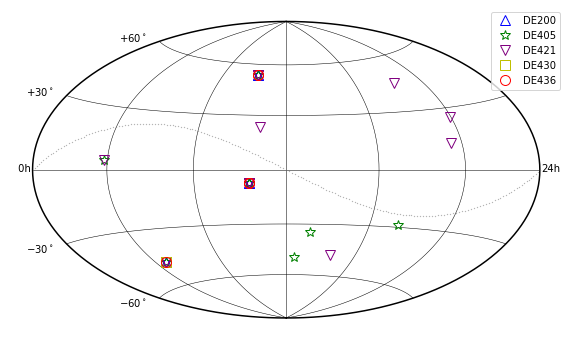

In [15]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.axis("off")

# Uniform sampling in longtitude and latitude
lon_arr = np.arange(0, 361, 5)
lat_arr = np.arange(-90, 91, 1)

# Plot a ellipse border.
lon_bords = np.array([0, 360])

# A loop to plot 7 grid.
for lon_bord in lon_bords:
    lat = lat_arr
    lon = np.ones_like(lat) * lon_bord
    X, Y = hammer_projection(lon, lat)
    ax.plot(X, Y, "k", linewidth=1.5)

# Grid plot.
# longtitude_grid_plot()
# 6 nodes in the longtitude from 0 to 360 deg.
lon_nodes = np.arange(60, 360, 60)

# A loop to plot 7 grid.
for lon_node in lon_nodes:
    lat = lat_arr
    lon = np.ones_like(lat) * lon_node
    X, Y = hammer_projection(lon, lat)
    ax.plot(X, Y, "k", linewidth=0.5)

# latitude_grid_plot()
# 5 nodes in the latitude from -60 to +60 deg.
lat_nodes = np.arange(-60, 61, 30)

# A loop to plot 7 grid.
for lat_node in lat_nodes:
    lon = lon_arr
    lat = np.ones_like(lon) * lat_node
    X, Y = hammer_projection(lon, lat)
    ax.plot(X, Y, "k", linewidth=0.5)

# Grid tickers.
# For fundamental plane.
lon0 = np.array([0, 360])
lat0 = np.array([0, 0])
X0, Y0 = hammer_projection(lon0, lat0)

ax.text(X0[0] - 0.2, Y0[0] - 0.025, " 0h")
ax.text(X0[1] + 0.02, Y0[1] - 0.025, "24h")

# For latitude grid
lon = np.array([0, 0])
lat = np.array([30, 60])
X, Y = hammer_projection(lon, lat)

for i in range(lat.size):
    ax.text(X[i] - 0.45, Y[i] - 0.0, "$+%d^\circ$" % lat[i])
    ax.text(X[i] - 0.45, -Y[i] - 0.1, "$-%d^\circ$" % lat[i])

# Plot the source.
shift = 0.025
# DE200
X, Y = hammer_projection(edr3_timing200["ra_g"], edr3_timing200["dec_g"])
ax.plot(X, Y, "^", mfc="none", mec="b", ms=10, label="DE200")

# DE405
X, Y = hammer_projection(edr3_timing405["ra_g"], edr3_timing405["dec_g"])
ax.plot(X, Y, "*", mfc="none", mec="g", ms=10, label="DE405")

# DE421
X, Y = hammer_projection(edr3_timing421["ra_g"], edr3_timing421["dec_g"])
ax.plot(X, Y, "v", mfc="none", mec="purple", ms=10, label="DE421")

# DE430
X, Y = hammer_projection(edr3_timing430["ra_g"], edr3_timing430["dec_g"])
ax.plot(X, Y, "s", mfc="none", mec="y", ms=10, label="DE430")

# DE436
X, Y = hammer_projection(edr3_timing436["ra_g"], edr3_timing436["dec_g"])
ax.plot(X, Y, "o", mfc="none", mec="r", ms=10, label="DE436")

# Ecliptic plane
lon_arr = np.arange(0, 361, 2)
lat_arr = np.zeros_like(lon_arr)
ecl_plane = SkyCoord(lon_arr, lat_arr, unit="deg",
                     frame="barycentricmeanecliptic")
ecl_plane_equ = ecl_plane.icrs
ecl_ra = ecl_plane_equ.ra.value
ecl_dec = ecl_plane_equ.dec.value
X, Y = hammer_projection(ecl_ra, ecl_dec)
ax.plot(X, Y, ".", ms=0.5, color="grey")

ax.legend()

## 1.4 Compute statistics of position formal uncertainties

In [16]:
# For comparison of positional uncertainty
pos_err_tab = np.zeros((5, 6))

pos_err_tab[0, :] = calc_med_pos_err(edr3_timing200)
pos_err_tab[1, :] = calc_med_pos_err(edr3_timing405)
pos_err_tab[2, :] = calc_med_pos_err(edr3_timing421)
pos_err_tab[3, :] = calc_med_pos_err(edr3_timing430)
pos_err_tab[4, :] = calc_med_pos_err(edr3_timing436)

/Users/Neo/Scisoft/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


## 1.5 Remove pulsars near the ecliptic plane

In [17]:
mask = (
    (edr3_timing["psr_name"] != "J0614+2229")
    & (edr3_timing["psr_name"] != "J0534+2200")
    & (edr3_timing["psr_name"] != "J0337+1715")
    & (edr3_timing["psr_name"] != "J2339-0533")
#     & (edr3_timing["psr_name"] != "J1723-2837")
#     & (edr3_timing["psr_name"] != "J2129-0429")
#     & (edr3_timing["psr_name"] != "J1023+0038")
)
edr3_timing = Table(edr3_timing[mask], masked=False)

In [18]:
count_psr_nb(edr3_timing)

There are 12 pulsars with 36 measurements.


# 2 Compare timing and Gaia reference frames

##  2.1 DE200 vs Gaia EDR3

In [19]:
mask = edr3_timing["eph"] == "DE200"
edr3_timing200 = edr3_timing[mask]

nb_psr_200 = len(edr3_timing200.group_by("psr_name").groups)
nb_obs_200 = len(edr3_timing200)

count_psr_nb(edr3_timing200)
edr3_timing200

There are 3 pulsars with 5 measurements.


psr_bname,psr_name,pos_epoch,eph,ra_t,dec_t,pmra_t,pmdec_t,plx_t,ra_err_t,dec_err_t,pmra_err_t,pmdec_err_t,plx_err_t,ref,comment,source_id,ra_g,ra_err_g,dec_g,dec_err_g,plx_g,plx_err_g,pmra_g,pmra_err_g,pmdec_g,pmdec_err_g,dra,ddec,dra_err,ddec_err
,,d,,deg,deg,mas / yr,mas / yr,mas,mas,mas,mas / yr,mas / yr,mas,,,,deg,mas,deg,mas,mas,mas,mas / yr,mas / yr,mas / yr,mas / yr,mas,mas,mas,mas
bytes10,bytes12,float64,bytes5,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes6,bytes13,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
J0437-4715,J0437-4715,49615.0,DE200,69.31556254166667,-47.25226463888889,121.3,-70.4,1.0,0.13821821060353065,0.2,0.2,0.30000000000000004,5.0,bbm+97,,4789864076732331648,69.31662758499,0.4591,-47.25268764316,0.5165,7.1008,0.5245,121.646,0.574,-70.697,0.65,-13.542585942929312,18.19352932593628,12.22566512761507,13.844827395476399
J1012+5307,J1012+5307,50700.0,DE200,153.1393070833333,53.117385666666664,2.4,-25.2,0.0,0.1620963638808497,0.4,0.2,0.2,0.0,lcw+01,,851610861391010944,153.13933086797,0.2043,53.11725939018,0.204,1.7448,0.2906,2.736,0.292,-25.921,0.271,-1.2882216866509926,-20.072980669378648,5.353493624594203,4.982855370360075
J1012+5307,J1012+5307,50914.0,DE200,153.13930791666667,53.11738166666667,2.3,-25.8,0.0,1.0806425264165949,2.0,0.7,0.8,0.0,hlk+04,,851610861391010944,153.13933086797,0.2043,53.11725939018,0.204,1.7448,0.2906,2.736,0.292,-25.921,0.271,-1.0907062974638593,-19.285864984405904,5.291603689575149,5.207509117753862
J1024-0719,J1024-0719,50456.0,DE200,156.16126666666665,-7.3219025,-41.0,-70.0,0.0,1.475636235828492,3.0,2.0,3.0,0.0,tsb+99,,3775277872387310208,156.16108773644,0.2544,-7.32217198666,0.2563,0.8572,0.2782,-35.458,0.318,-48.352,0.357,-34.10226973775073,52.42373506807588,6.218661423952087,7.414762096101999
J1024-0719,J1024-0719,51018.0,DE200,156.16125125,-7.321920833333333,-35.0,-48.0,0.0,5.902544700634462,15.0,4.0,8.0,0.0,hlk+04,,3775277872387310208,156.16108773644,0.2544,-7.32217198666,0.2563,0.8572,0.2782,-35.458,0.318,-48.352,0.357,-34.591441343089976,60.821610496232104,8.103529905512335,16.243039568406545


/Users/Neo/Github/pulsar-crf-comparison/progs/psrcrf_tools.py:666: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


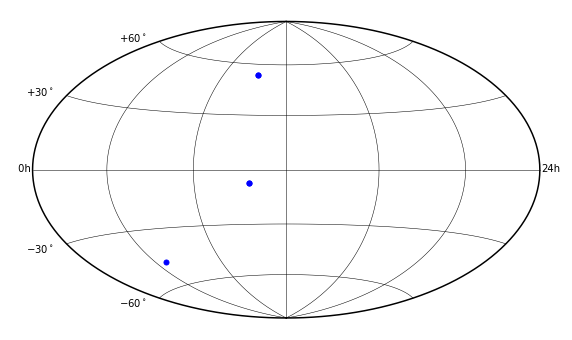

In [20]:
sou_dist_plot(
    edr3_timing200["ra_g"],
    edr3_timing200["dec_g"],
)
#               "../plots/de200_gedr3_psr.eps")

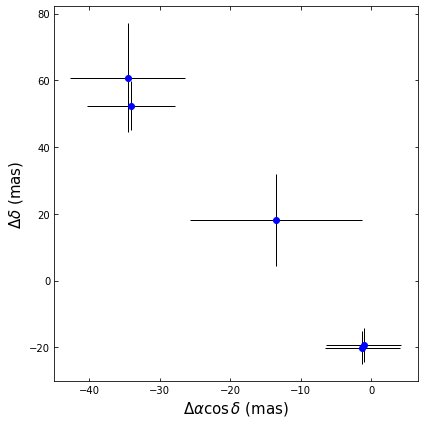

In [21]:
simple_plot(edr3_timing200)

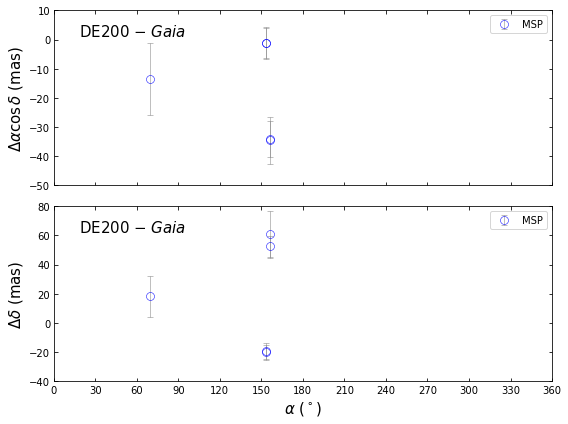

In [22]:
pos_oft_vs_coord(
    edr3_timing200,
    [-50, 10, -40, 80],
    # Prefit
    edr3_timing200["dra"],
    edr3_timing200["ddec"],
    # Postfit
    #                  dra_200,
    #                  ddec_200,
    add_text=[0.05, 0.85, "DE200 $-$ $Gaia$"],
    ref="g",
    xaxis="ra",
    divided=True)

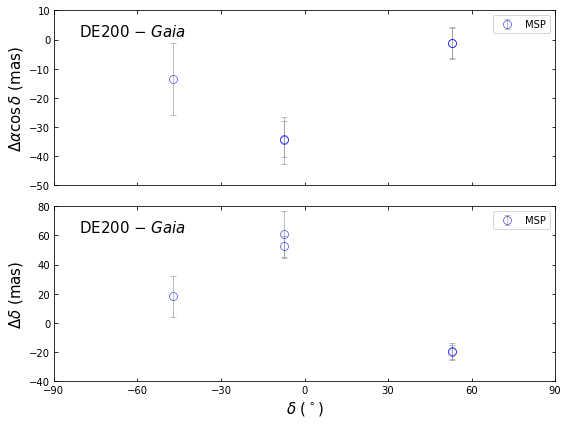

In [23]:
pos_oft_vs_coord(
    edr3_timing200,
    [-50, 10, -40, 80],
    # Prefit
    edr3_timing200["dra"],
    edr3_timing200["ddec"],
    # Postfit
    #                  dra_200,
    #                  ddec_200,
    add_text=[0.05, 0.85, "DE200 $-$ $Gaia$"],
    ref="g",
    xaxis="dec",
    divided=True)

In [24]:
pmt200, sig200, indx, apr_chi2_200, pst_chi2_200 = rot_fit_4_table(edr3_timing200)

Iter.  NO.PSR  Apr.Chi2  Pos.Chi2  R1  R2  R3  rmPSR  rmPSREpoch  rmPSRChi2
Unit: mas
 1  3     24.2     16.1      16.12     -11.16     -29.76 J1024-0719    50456     57.4
 2  3     16.3      6.6       9.93     -21.66     -27.04 J1024-0719    51018     22.7


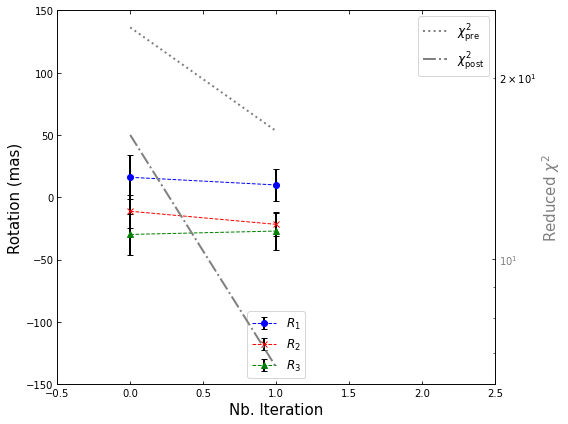

In [25]:
rot_vs_iter(
    pmt200,
    sig200,
    [-0.5, 2.5, -150, 150],
    #             "gedr3_orient-de200.eps",
#     add_text=[0.1, 0.2, "DE200 $-$ $Gaia$"],
    apr_chi2=apr_chi2_200,
    pst_chi2=pst_chi2_200,
    ax_loc="lower center",
    ax1_loc="upper right",
)

I used the median values of the parameter estimations as the final estimate of rotation parameters.

The uncertainties of these estimates are given by interquatile range scaled by a factor of 1/1.35.

This was done also for the comparison of DE405, DE421, DE430, and DE436.

In [26]:
rot200, iqr200 = find_pmt_est(pmt200)

Calculate the postfit residuals.

In [27]:
dra_200, ddec_200 = calc_dpos(edr3_timing200, rot200)

Calculate the reduced $\chi^2$ before and after the LSQ adjustements.

In [28]:
a_chi2_200, p_chi2_200 = calc_chi2_4_fit(edr3_timing200, dra_200, ddec_200)

In [29]:
rot200, iqr200, dra_200, ddec_200, a_chi2_200, p_chi2_200 = simple_rot_fit_4_table(
    edr3_timing200, ref="g")

[msg] There are 5 timing solutions for 3 pulsars
[msg] Before removing outliers, the reduced chi-squared is 16.14.
[msg] There is no outliers.
[info] NO.Obs  NO.PSR  Apr.Chi2  Pos.Chi2  R1  R2  R3  R1_err  R2_err R3_err
[info] Unit: mas
[info]  5  3     16.1     16.1      16.12     -11.16     -29.76      17.66      13.13      16.11


## 2.2 DE405 vs Gaia EDR3

In [30]:
mask = edr3_timing["eph"] == "DE405"
edr3_timing405 = edr3_timing[mask]

nb_psr_405 = len(edr3_timing405.group_by("psr_name").groups)
nb_obs_405 = len(edr3_timing405)

count_psr_nb(edr3_timing405)
edr3_timing405

There are 7 pulsars with 8 measurements.


psr_bname,psr_name,pos_epoch,eph,ra_t,dec_t,pmra_t,pmdec_t,plx_t,ra_err_t,dec_err_t,pmra_err_t,pmdec_err_t,plx_err_t,ref,comment,source_id,ra_g,ra_err_g,dec_g,dec_err_g,plx_g,plx_err_g,pmra_g,pmra_err_g,pmdec_g,pmdec_err_g,dra,ddec,dra_err,ddec_err
,,d,,deg,deg,mas / yr,mas / yr,mas,mas,mas,mas / yr,mas / yr,mas,,,,deg,mas,deg,mas,mas,mas,mas / yr,mas / yr,mas / yr,mas / yr,mas,mas,mas,mas
bytes10,bytes12,float64,bytes5,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes6,bytes13,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
J0348+0432,J0348+0432,56000.0,DE405,57.1818291667,4.5365161111,4.04,3.5,0.0,5.845301990505068,24.782,0.0,0.0,0.0,lbs+20,UTMOST-II,3273288485744249344,57.1818333178,0.6955,4.53651619578,0.6465,-0.0351,0.7841,3.438,1.345,-0.226,0.887,-1.8275654729327537,-1.1639883144965388,7.797070192419635,25.0187017318764
J0437-4715,J0437-4715,53019.0,DE405,69.31603281125,-47.252450716666665,121.31,-71.53,0.0,0.00552870899843772,0.008,0.01,0.01,0.0,hbo06,,4789864076732331648,69.31662758499,0.4591,-47.25268764316,0.5165,7.1008,0.5245,121.646,0.574,-70.697,0.65,1.8913110100383195,7.184406811853711,6.882116774201494,7.793114206728155
J1012+5307,J1012+5307,50700.0,DE405,153.13930875416665,53.117389083333336,2.562,-25.61,1.22,0.05349179582954307,0.13,0.014,0.02,0.26,lwj+09,,851610861391010944,153.13933086797,0.2043,53.11725939018,0.204,1.7448,0.2906,2.736,0.292,-25.921,0.271,2.3218568606521877,-7.7729806492740865,5.351306394667423,4.968475384051554
J1024-0719,J1024-0719,53000.0,DE405,156.161201875,-7.321991722222222,-34.9,-47.0,0.0,0.2951271881134008,0.6000000000000001,0.4,1.0,0.0,hbo06,,3775277872387310208,156.16108773644,0.2544,-7.32217198666,0.2563,0.8572,0.2782,-35.458,0.318,-48.352,0.357,-18.481915645989176,67.99988291295168,3.840604664208689,4.338713425249384
J1024-0719,J1024-0719,53000.0,DE405,156.16120191666664,-7.3219916666666665,-35.3,-48.2,0.0,0.44269078222525615,1.0,0.2,0.30000000000000004,0.0,vbc+09,,3775277872387310208,156.16108773644,0.2544,-7.32217198666,0.2563,0.8572,0.2782,-35.458,0.318,-48.352,0.357,-18.333138917466318,68.19988291351254,3.854752814156184,4.411851559882681
J1227-4853,J1227-4853,56708.0,DE405,186.99468333333328,-48.895205833333335,0.0,0.0,0.0,6.483377913184578,3.0,0.0,0.0,0.0,rbb+15,,6128369984328414336,186.99465510705,0.0972,-48.89519662091,0.0607,0.4635,0.1276,-18.772,0.106,7.297,0.088,31.829888777960168,-19.56915738683976,6.487113516034605,3.005090196718065
J1311-3430,J1311-3430,55266.9,DE405,197.94051749999997,-34.508430555555556,0.0,0.0,0.0,2.0371396176208703,4.0,0.0,0.0,0.0,pgf+12,,6179115508262195200,197.94050550831,1.1444,-34.5084379066,0.6258,1.9312,0.9698,-6.133,1.604,-5.145,0.684,-0.050164497031824275,-3.421500439105064,9.60552194928722,5.672479492865178
J1723-2837,J1723-2837,55667.0,DE405,260.8466066666666,-28.63254722222222,0.0,0.0,0.0,9.244506892240288,110.0,0.0,0.0,0.0,cls+13,,4059795674516044800,260.8465812119,0.0355,-28.63266533424,0.0253,1.0663,0.0439,-11.734,0.044,-24.05,0.034,25.126036733080298,311.8505603691683,9.24690082739917,110.00011963574535


/Users/Neo/Github/pulsar-crf-comparison/progs/psrcrf_tools.py:666: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


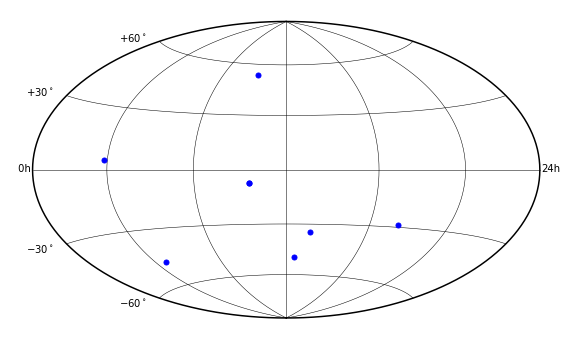

In [31]:
sou_dist_plot(
    edr3_timing405["ra_g"],
    edr3_timing405["dec_g"],
)
#               "../plots/gedr3_de405_psr.eps")

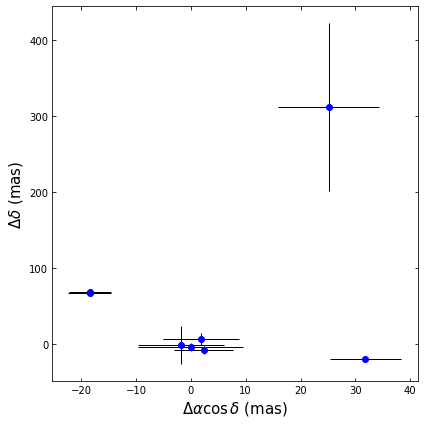

In [32]:
simple_plot(edr3_timing405)

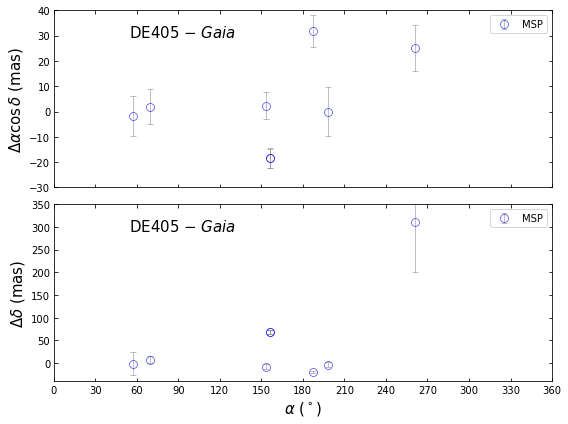

In [33]:
pos_oft_vs_coord(edr3_timing405, [-30, 40, -40, 350],
                 edr3_timing405["dra"],
                 edr3_timing405["ddec"],
                 add_text=[0.15, 0.85, "DE405 $-$ $Gaia$"],
                 ref="g",
                 xaxis="ra",
                 divided=True)

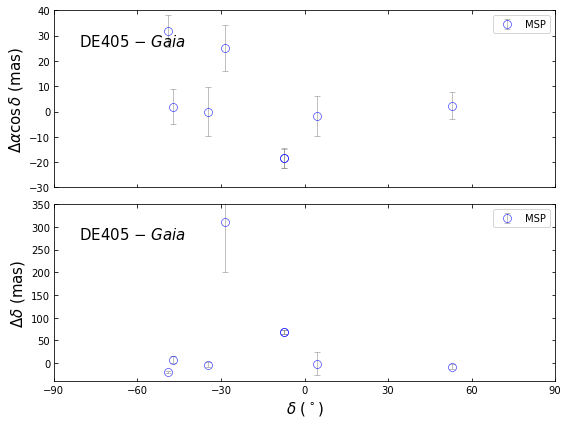

In [34]:
pos_oft_vs_coord(edr3_timing405, [-30, 40, -40, 350],
                 edr3_timing405["dra"],
                 edr3_timing405["ddec"],
                 add_text=[0.05, 0.8, "DE405 $-$ $Gaia$"],
                 ref="g",
                 xaxis="dec",
                 divided=True)

In [35]:
pmt405, sig405, indx, apr_chi2_405, pst_chi2_405 = rot_fit_4_table(edr3_timing405)

Iter.  NO.PSR  Apr.Chi2  Pos.Chi2  R1  R2  R3  rmPSR  rmPSREpoch  rmPSRChi2
Unit: mas
 1  7     51.4     40.0      30.70      10.41      -6.11 J1024-0719    53000    118.7
 2  7     34.7     32.4      17.12       1.23      -2.26 J1024-0719    53000    199.4
 3  6     10.7      4.2      -7.83     -14.86      10.83 J1227-4853    56708     11.0
 4  5      3.2      2.4      -1.22      -6.64       5.16 J1723-2837    55667     11.6
 5  4      1.0      0.4       0.88      -5.39       0.69 J1012+5307    50700      0.5
 6  3      0.7      0.1       6.13      -1.27       0.50 J0437-4715    53019      0.0


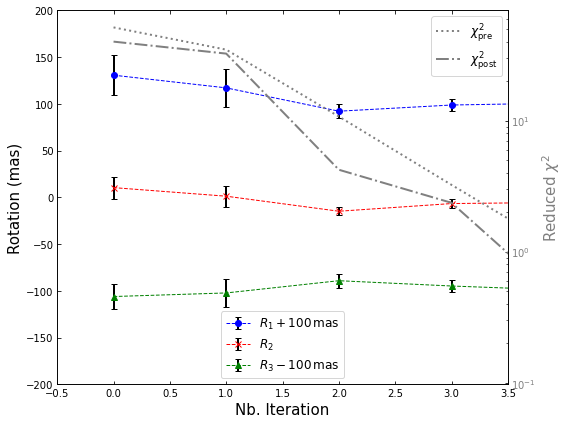

In [36]:
rot_vs_iter(
    pmt405,
    sig405,
    [-0.5, 3.5, -200, 200],
    #             "gedr3_orient-de405.eps",
#     add_text=[1, 75, "DE405 $-$ $Gaia$"],
    apr_chi2=apr_chi2_405,
    pst_chi2=pst_chi2_405,
    ax_loc="lower center",
    ax1_loc="upper right",
    y_shift=100
)

In [37]:
rot405, iqr405 = find_pmt_est(pmt405)

dra_405, ddec_405 = calc_dpos(edr3_timing405, rot405)

a_chi2_405, p_chi2_405 = calc_chi2_4_fit(edr3_timing405, dra_405, ddec_405)

## 2.3 DE421 vs Gaia EDR3

In [38]:
mask = edr3_timing["eph"] == "DE421"
edr3_timing421 = edr3_timing[mask]

nb_psr_421 = len(edr3_timing421.group_by("psr_name").groups)
nb_obs_421 = len(edr3_timing421)

count_psr_nb(edr3_timing421)
edr3_timing421

There are 9 pulsars with 16 measurements.


psr_bname,psr_name,pos_epoch,eph,ra_t,dec_t,pmra_t,pmdec_t,plx_t,ra_err_t,dec_err_t,pmra_err_t,pmdec_err_t,plx_err_t,ref,comment,source_id,ra_g,ra_err_g,dec_g,dec_err_g,plx_g,plx_err_g,pmra_g,pmra_err_g,pmdec_g,pmdec_err_g,dra,ddec,dra_err,ddec_err
,,d,,deg,deg,mas / yr,mas / yr,mas,mas,mas,mas / yr,mas / yr,mas,,,,deg,mas,deg,mas,mas,mas,mas / yr,mas / yr,mas / yr,mas / yr,mas,mas,mas,mas
bytes10,bytes12,float64,bytes5,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes6,bytes13,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
J0348+0432,J0348+0432,56000.0,DE421,57.18182916666666,4.536516111111111,4.04,3.5,0.0,0.05962464415286627,0.2,0.16,0.6000000000000001,0.0,afw+13,,3273288485744249344,57.1818333178,0.6955,4.53651619578,0.6465,-0.0351,0.7841,3.438,1.345,-0.226,0.887,-1.8276851161224574,-1.1639483144932292,5.160455728276971,3.4391732071233956
J0437-4715,J0437-4715,54500.0,DE421,69.3162340617,-47.2525307528,121.441,-71.475,6.441,0.002534452271583702,0.00383898,0.001714,0.001865,0.074791,vlh+16,IPTA-DR1,4789864076732331648,69.31662758499,0.4591,-47.25268764316,0.5165,7.1008,0.5245,121.646,0.574,-70.697,0.65,0.41362232710380126,5.713483553951596,4.562511672888209,5.166268232441913
J0437-4715,J0437-4715,54500.0,DE421,69.3162340571,-47.2525307528,121.439,-71.475,6.373,0.0040927843038688965,0.00626552,0.001915,0.001954,0.086288,rhc+16,PPTA-DR1e,4789864076732331648,69.31662758499,0.4591,-47.25268764316,0.5165,7.1008,0.5245,121.646,0.574,-70.697,0.65,0.40238196494322276,5.713483553951596,4.562512804658876,5.166270605428244
J0437-4715,J0437-4715,54500.0,DE421,69.3162340571,-47.2525307528,121.439,-71.475,6.373,4.1591032737175135,3.0352,0.0,0.0,0.0,lbs+20,UTMOST-II,4789864076732331648,69.31662758499,0.4591,-47.25268764316,0.5165,7.1008,0.5245,121.646,0.574,-70.697,0.65,0.40238196494322276,5.713483553951596,6.17370604930625,5.991890498980355
J1012+5307,J1012+5307,55000.0,DE421,153.13932300416664,53.11730555277778,2.609,-25.482,0.71,0.027016110990482865,0.060000000000000005,0.008,0.011,0.17,dcl+16,EPTA,851610861391010944,153.13933086797,0.2043,53.11725939018,0.204,1.7448,0.2906,2.736,0.292,-25.921,0.271,0.9007883289115525,-3.3213105650496413,1.9205802638109293,1.7848773222548298
J1012+5307,J1012+5307,55000.0,DE421,153.1393230512,53.1173055972,2.627,-25.458,0.782,0.030519273783717916,0.06366704,0.010222,0.013951,0.193807,vlh+16,IPTA-DR1,851610861391010944,153.13933086797,0.2043,53.11725939018,0.204,1.7448,0.2906,2.736,0.292,-25.921,0.271,1.0024107320443398,-3.1613905646075704,1.9206327357304138,1.7850043550316432
J1012+5307,J1012+5307,54902.0,DE421,153.1393227083333,53.117307527777776,2.5,-25.6,1.0,0.3241933169926904,0.7000000000000001,0.2,0.2,3.0,mnf+16,NANOGrav-9yr,851610861391010944,153.13933086797,0.2043,53.11725939018,0.204,1.7448,0.2906,2.736,0.292,-25.921,0.271,0.9956918279925261,-3.1661579427033795,2.0244361108433746,1.9837310605409721
J1024-0719,J1024-0719,55000.0,DE421,156.16114740833333,-7.322064986111111,-35.28,-48.18,0.8,0.07378178490567323,0.15,0.03,0.07,0.17,dcl+16,EPTA,3775277872387310208,156.16108773644,0.2544,-7.32217198666,0.2563,0.8572,0.2782,-35.458,0.318,-48.352,0.357,-18.805495527107208,69.01100543154543,2.0963175838429273,2.3533624520292755


/Users/Neo/Github/pulsar-crf-comparison/progs/psrcrf_tools.py:666: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


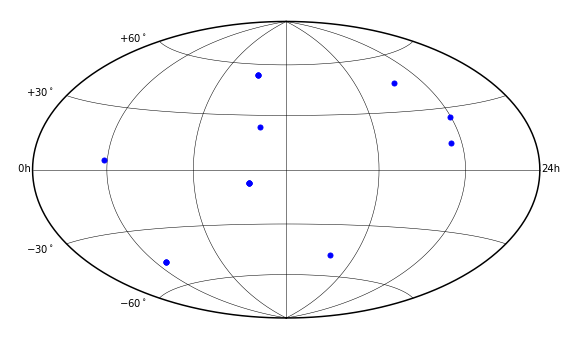

In [39]:
sou_dist_plot(
    edr3_timing421["ra_g"],
    edr3_timing421["dec_g"],
)
#               "../plots/gedr3_de421_psr.eps")

In [40]:
pos_err_tab[2, :] = calc_med_pos_err(edr3_timing421)

/Users/Neo/Scisoft/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


We have 12 pulsars in the sample from DE421 vs. Gaia comparison.

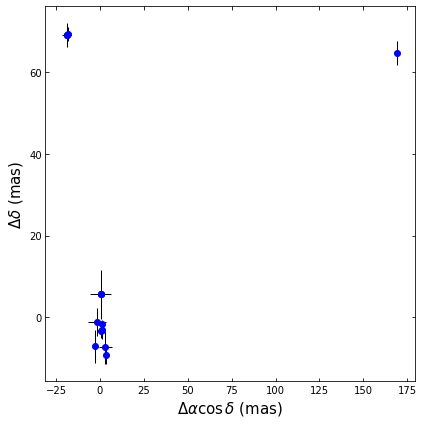

In [41]:
simple_plot(edr3_timing421)

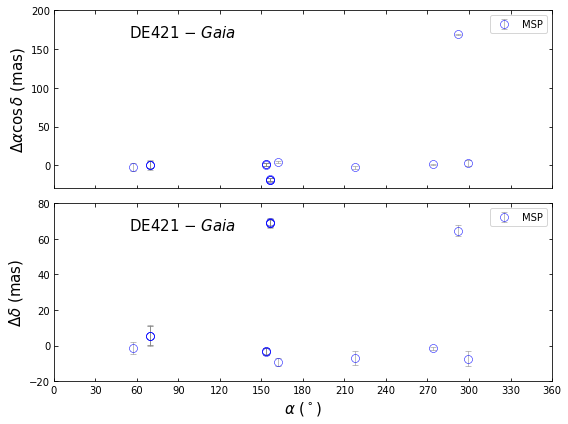

In [42]:
pos_oft_vs_coord(edr3_timing421, [-30, 200, -20, 80],
                 edr3_timing421["dra"],
                 edr3_timing421["ddec"],
                 add_text=[0.15, 0.85, "DE421 $-$ $Gaia$"],
                 ref="g",
                 xaxis="ra",
                 divided=True)

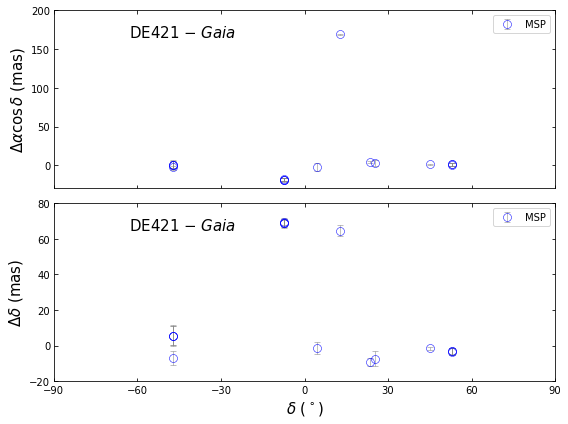

In [43]:
pos_oft_vs_coord(edr3_timing421, [-30, 200, -20, 80],
                 edr3_timing421["dra"],
                 edr3_timing421["ddec"],
                 add_text=[0.15, 0.85, "DE421 $-$ $Gaia$"],
                 ref="g",
                 xaxis="dec",
                 divided=True)

In [44]:
pmt421, sig421, indx, apr_chi2_421, pst_chi2_421 = rot_fit_4_table(edr3_timing421)

Iter.  NO.PSR  Apr.Chi2  Pos.Chi2  R1  R2  R3  rmPSR  rmPSREpoch  rmPSRChi2
Unit: mas
 1  9   1442.5   1133.1      -3.43      17.83      37.61 J1928+1245    57974  20887.2
 2  8    177.8    125.8       8.94      17.89      -9.69 J1024-0719    55800    983.9
 3  8    107.7     88.7       6.29      10.89      -6.07 J1024-0719    55000    613.5
 4  8     74.7     66.5       4.71       6.80      -3.64 J1024-0719    55000    720.5
 5  8     35.2     33.8       2.78       1.97      -0.49 J1024-0719    54500    592.5
 6  7      3.2      2.2       1.20      -1.92       2.27 J1048+2339    56700     13.6
 7  6      1.9      1.5       1.26      -0.78       1.39 J1816+4510    56047      2.3
 8  5      1.7      1.0       2.18      -3.19      -2.12 J1431-4715    55756      1.7
 9  4      1.4      0.8       0.31      -2.84       0.54 J1957+2516    56408      5.2
10  3      1.3      0.4       0.08      -3.25       0.04 J1012+5307    55000      0.1
11  3      1.2      0.5       0.29      -3.11       0.

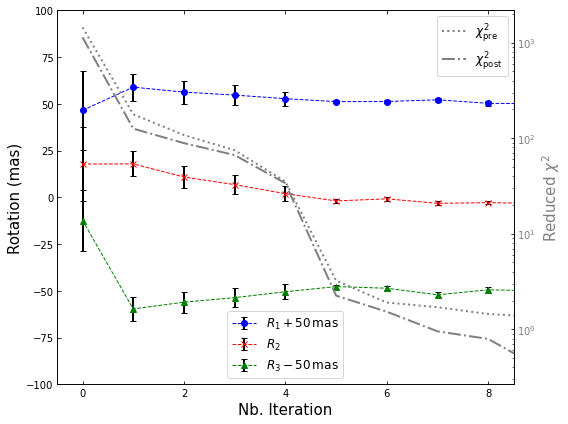

In [45]:
rot_vs_iter(
    pmt421,
    sig421,
    [-0.5, 12.5, -100, 100],
    #             "gedr3_orient-de421.eps",
    xaxis_range=np.arange(0, 10, 2),
#     add_text=[2, 55, "DE421 $-$ $Gaia$"],
    apr_chi2=apr_chi2_421,
    pst_chi2=pst_chi2_421,
    ax_loc="lower center",
    ax1_loc="upper right",
    y_shift=50
)

In [46]:
rot421, iqr421 = find_pmt_est(pmt421)

dra_421, ddec_421 = calc_dpos(edr3_timing421, rot421)

a_chi2_421, p_chi2_421 = calc_chi2_4_fit(edr3_timing421, dra_421, ddec_421)

## 2.4 DE430 vs Gaia EDR3

In [47]:
mask = edr3_timing["eph"] == "DE430"
edr3_timing430 = edr3_timing[mask]

nb_psr_430 = len(edr3_timing430.group_by("psr_name").groups) # nb_psr_430= 1
nb_obs_430 = len(edr3_timing430) # nb_obs_430=1

count_psr_nb(edr3_timing430)
edr3_timing430

There are 1 pulsars with 1 measurements.


psr_bname,psr_name,pos_epoch,eph,ra_t,dec_t,pmra_t,pmdec_t,plx_t,ra_err_t,dec_err_t,pmra_err_t,pmdec_err_t,plx_err_t,ref,comment,source_id,ra_g,ra_err_g,dec_g,dec_err_g,plx_g,plx_err_g,pmra_g,pmra_err_g,pmdec_g,pmdec_err_g,dra,ddec,dra_err,ddec_err
,,d,,deg,deg,mas / yr,mas / yr,mas,mas,mas,mas / yr,mas / yr,mas,,,,deg,mas,deg,mas,mas,mas,mas / yr,mas / yr,mas / yr,mas / yr,mas,mas,mas,mas
bytes10,bytes12,float64,bytes5,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes6,bytes13,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
J0437-4715,J0437-4715,57600.0,DE430,69.316656,-47.252699166666666,121.48,-71.43,0.0,0.0691085382657124,0.1,0.02,0.01,0.0,jbs+19,UTMOST-I,4789864076732331648,69.31662758499,0.4591,-47.25268764316,0.5165,7.1008,0.5245,121.646,0.574,-70.697,0.65,-1.0060340234909115,-0.5471414458040094,0.5709849538780142,0.6468683782804632


/Users/Neo/Github/pulsar-crf-comparison/progs/psrcrf_tools.py:666: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


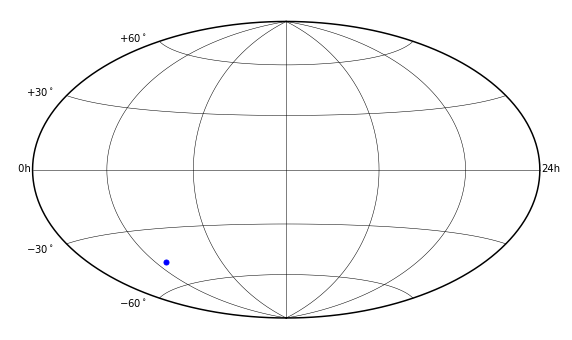

In [48]:
sou_dist_plot(
    edr3_timing430["ra_g"],
    edr3_timing430["dec_g"],
)
#               "../plots/gedr3_de430_psr.eps")

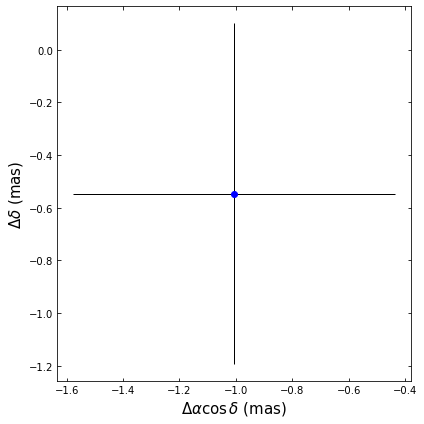

In [49]:
simple_plot(edr3_timing430, "gedr3_pos-com-de430.eps")

## 2.5 DE436 vs Gaia EDR3

In [50]:
mask = edr3_timing["eph"] == "DE436"
edr3_timing436 = edr3_timing[mask]

nb_psr_436 = len(edr3_timing436.group_by("psr_name").groups)
nb_obs_436 = len(edr3_timing436)

count_psr_nb(edr3_timing436)
edr3_timing436

There are 3 pulsars with 6 measurements.


psr_bname,psr_name,pos_epoch,eph,ra_t,dec_t,pmra_t,pmdec_t,plx_t,ra_err_t,dec_err_t,pmra_err_t,pmdec_err_t,plx_err_t,ref,comment,source_id,ra_g,ra_err_g,dec_g,dec_err_g,plx_g,plx_err_g,pmra_g,pmra_err_g,pmdec_g,pmdec_err_g,dra,ddec,dra_err,ddec_err
,,d,,deg,deg,mas / yr,mas / yr,mas,mas,mas,mas / yr,mas / yr,mas,,,,deg,mas,deg,mas,mas,mas,mas / yr,mas / yr,mas / yr,mas / yr,mas,mas,mas,mas
bytes10,bytes12,float64,bytes5,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes6,bytes13,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
J0437-4715,J0437-4715,55000.0,DE436,69.3163022208,-47.2525579444,121.443,-71.474,6.418,0.0034208667568033754,0.00530447,0.001435,0.00156,0.067263,pdd+19,IPTA-DR2,4789864076732331648,69.31662758499,0.4591,-47.25268764316,0.5165,7.1008,0.5245,121.646,0.574,-70.697,0.65,0.4400840778267535,4.602642086589747,3.7815641724289644,4.281850764432323
J1012+5307,J1012+5307,55000.0,DE436,153.1393230429,53.1173056083,2.614,-25.486,0.933,0.029729203746393654,0.06394984,0.010224,0.013773,0.192303,pdd+19,IPTA-DR2,851610861391010944,153.13933086797,0.2043,53.11725939018,0.204,1.7448,0.2906,2.736,0.292,-25.921,0.271,0.9844773920717708,-3.12143056769615,1.9206203438062408,1.785014464237082
J1012+5307,J1012+5307,55291.0,DE436,153.139324,53.11730002777778,2.66,-25.5,1.3,0.05403222892479656,0.1,0.03,0.04,0.4,abb+18,NANOGrav-11yr,851610861391010944,153.13933086797,0.2043,53.11725939018,0.204,1.7448,0.2906,2.736,0.292,-25.921,0.271,0.8726200828719868,-2.559671957179279,1.6901150344139952,1.5727519522956015
J1024-0719,J1024-0719,55636.0,DE436,156.1611309125,-7.322087388888889,-35.27,-48.22,0.83,0.059025424959002266,0.1,0.017,0.03,0.13,rsc+21,PPTA-DR2e,3775277872387310208,156.16108773644,0.2544,-7.32217198666,0.2563,0.8572,0.2782,-35.458,0.318,-48.352,0.357,-15.964160993669262,72.55504239258222,1.5479793851124006,1.7348689477526171
J1024-0719,J1024-0719,55000.0,DE436,156.1611475046,-7.3220649306,-35.267,-48.225,0.822,0.04761904337019902,0.09847672,0.017593,0.036161,0.102243,pdd+19,IPTA-DR2,3775277872387310208,156.16108773644,0.2544,-7.32217198666,0.2563,0.8572,0.2782,-35.458,0.318,-48.352,0.357,-18.46176167772735,69.21084543209305,2.0955598855286084,2.3506408689978997
J1024-0719,J1024-0719,56239.0,DE436,156.16111399166664,-7.3221103888888885,-35.29,-48.2,0.8,0.08853813287160019,0.2,0.06,0.1,0.2,abb+18,NANOGrav-11yr,3775277872387310208,156.16108773644,0.2544,-7.32217198666,0.2563,0.8572,0.2782,-35.458,0.318,-48.352,0.357,-17.84394723600126,69.58052083322342,1.0364132500526133,1.169625019245252


/Users/Neo/Github/pulsar-crf-comparison/progs/psrcrf_tools.py:666: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


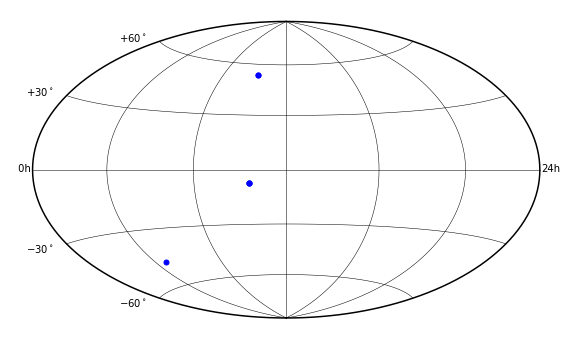

In [51]:
sou_dist_plot(
    edr3_timing436["ra_g"],
    edr3_timing436["dec_g"],
)
#               "../plots/gedr3_de436_psr.eps")

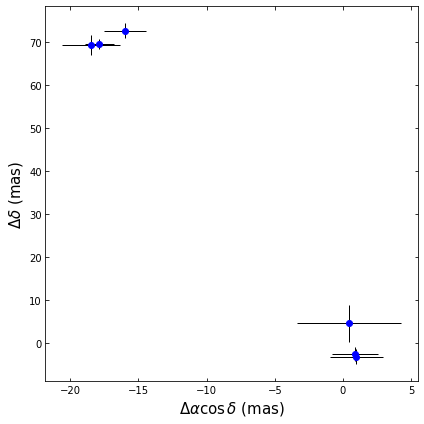

In [52]:
simple_plot(edr3_timing436)

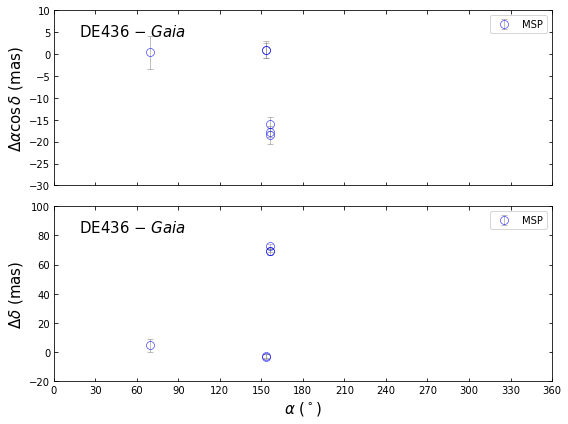

In [53]:
pos_oft_vs_coord(edr3_timing436, [-30, 10, -20, 100],
                 edr3_timing436["dra"],
                 edr3_timing436["ddec"],
                 add_text=[0.05, 0.85, "DE436 $-$ $Gaia$"],
                 ref="g",
                 xaxis="ra",
                 divided=True)

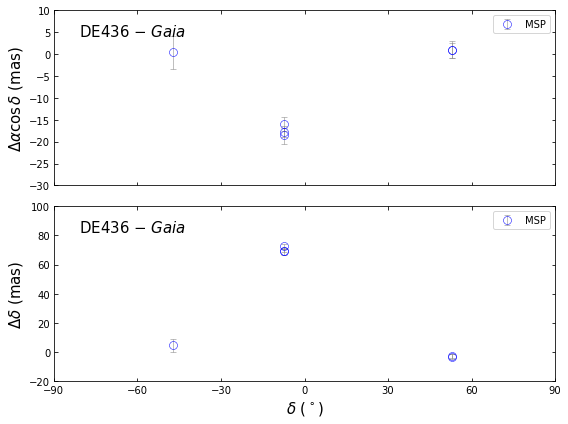

In [54]:
pos_oft_vs_coord(edr3_timing436, [-30, 10, -20, 100],
                 edr3_timing436["dra"],
                 edr3_timing436["ddec"],
                 add_text=[0.05, 0.85, "DE436 $-$ $Gaia$"],
                 ref="g",
                 xaxis="dec",
                 divided=True)

In [55]:
pmt436, sig436, indx, apr_chi2_436, pst_chi2_436 = rot_fit_4_table(edr3_timing436)

Iter.  NO.PSR  Apr.Chi2  Pos.Chi2  R1  R2  R3  rmPSR  rmPSREpoch  rmPSRChi2
Unit: mas
 1  3    830.3    314.1      26.63      35.05     -15.88 J1024-0719    56239    523.9
 2  3    467.9    281.0      20.24      21.00     -14.69 J1024-0719    55636    677.8
 3  3    238.0    191.8      14.01       6.21     -14.11 J1024-0719    55000    608.4


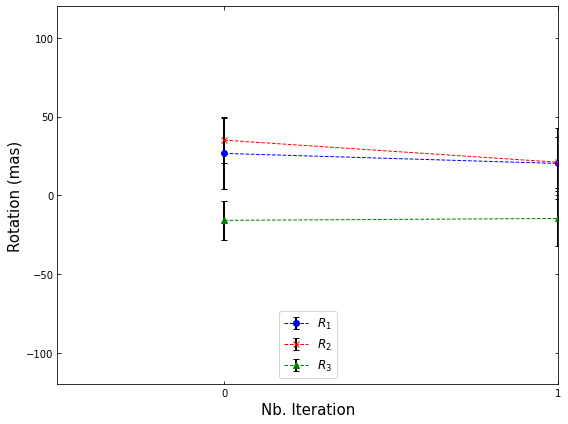

In [56]:
rot_vs_iter(
    pmt436,
    sig436,
    [-0.5, 3.5, -120, 120],
    #             "gedr3_orient-de421.eps",
    xaxis_range=np.arange(0, 2, 1),
#     add_text=[0, 0, "DE436 $-$ $Gaia$"],
    #             apr_chi2=apr_chi2_436,
    #             pst_chi2=pst_chi2_436,
    ax_loc="lower center",
    ax1_loc="upper right",
)

In [57]:
# rot436, iqr436 = find_pmt_est(pmt436)

# dra_436, ddec_436 = calc_dpos(edr3_timing436, rot436)

# a_chi2_436, p_chi2_436 = calc_chi2_4_fit(edr3_timing436, dra_436, ddec_436)

rot436, iqr436, dra_436, ddec_436, a_chi2_436, p_chi2_436 = simple_rot_fit_4_table(
    edr3_timing436, ref="g")

[msg] There are 6 timing solutions for 3 pulsars
[msg] Before removing outliers, the reduced chi-squared is 603.89.
[msg] There is no outliers.
[info] NO.Obs  NO.PSR  Apr.Chi2  Pos.Chi2  R1  R2  R3  R1_err  R2_err R3_err
[info] Unit: mas
[info]  6  3    603.9    314.1      26.63      35.05     -15.88      22.65      14.73      12.50


A short table to summarize the orientation between DE frame and Gaia frame.

In [58]:
mydata = [
    [
        nb_psr_200,
        nb_obs_200,
        rot200[0],
        iqr200[0],
        rot200[1],
        iqr200[1],
        rot200[2],
        iqr200[2],
        a_chi2_200,
        p_chi2_200,
    ],
    [
        nb_psr_405,
        nb_obs_405,
        rot405[0],
        iqr405[0],
        rot405[1],
        iqr405[1],
        rot405[2],
        iqr405[2],
        a_chi2_405,
        p_chi2_405,
    ],
    [
        nb_psr_421,
        nb_obs_421,
        rot421[0],
        iqr421[0],
        rot421[1],
        iqr421[1],
        rot421[2],
        iqr421[2],
        a_chi2_421,
        p_chi2_421,
    ],
    [
        nb_psr_436,
        nb_obs_436,
        rot436[0],
        iqr436[0],
        rot436[1],
        iqr436[1],
        rot436[2],
        iqr436[2],
        a_chi2_436,
        p_chi2_436,
    ],
]

myheaders = [
    "Nb.PSR",
    "Nb.Obs",
    "R1",
    "R1_err",
    "R2",
    "R2_err",
    "R3",
    "R3_err",
    "ApreFitChi2",
    "PostFitChi2",
]
mystubs = ["DE200", "DE405", "DE421", "DE436"]

tbl = SimpleTable(
    mydata,
    myheaders,
    mystubs,
    title="Orientation of DE frame wrt. Gaia frame  for MSP (mas)",
    data_fmts=[
        "%d",
        "%d",
        "%6.1f",
        "%6.1f",
        "%6.1f",
        "%6.1f",
        "%6.1f",
        "%6.1f",
        "%6.2f",
        "%6.2f",
    ],
)

print(tbl)

                Orientation of DE frame wrt. Gaia frame  for MSP (mas)               
      Nb.PSR Nb.Obs   R1   R1_err   R2   R2_err   R3   R3_err ApreFitChi2 PostFitChi2
-------------------------------------------------------------------------------------
DE200      3      5   16.1   17.7  -11.2   13.1  -29.8   16.1       16.14       16.07
DE405      7      8    3.5   11.2   -3.3    5.1    0.6    4.2       41.08       41.70
DE421      9     16    1.2    2.2   -1.3    7.9    0.1    2.4     1302.90     1309.86
DE436      3      6   26.6   22.6   35.1   14.7  -15.9   12.5      603.89      314.06
-------------------------------------------------------------------------------------


In [59]:
myheaders = ["RA_err_t", "dec_err_t", "pos_err_t", "RA_err_g", "dec_err_g", "pos_err_t"]
mystubs = ["DE200", "DE405", "DE421", "DE430", "DE436"]

tbl = SimpleTable(
    pos_err_tab,
    myheaders,
    mystubs,
    title="Positional formal uncertainty for timing and Gaia positions for MSP (mas)",
    data_fmts=["%6.2f", "%6.2f", "%6.2f", "%6.2f", "%6.2f", "%6.2f"],
)

print(tbl)

Positional formal uncertainty for timing and Gaia positions for MSP (mas)
      RA_err_t dec_err_t pos_err_t RA_err_g dec_err_g pos_err_t
---------------------------------------------------------------
DE200     1.08      2.00      2.27     0.25      0.26      0.36
DE405     1.24      2.00      2.79     0.25      0.26      0.36
DE421     0.11      0.25      0.27     0.25      0.26      0.36
DE430     0.07      0.10      0.12     0.46      0.52      0.69
DE436     0.05      0.10      0.11     0.25      0.26      0.36
---------------------------------------------------------------
